In [1]:
import os
os.environ['TEJAPI_KEY'] = "SZf1BjNEcKQhvQmn96eLrNL60Q2RH1"
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
import TejToolAPI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import alphalens
from zipline.pipeline import Pipeline
from logbook import Logger, StderrHandler, INFO

c:\Users\bca5j\anaconda3\envs\kebulin\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\bca5j\anaconda3\envs\kebulin\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\bca5j\anaconda3\envs\kebulin\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

In [3]:
from zipline.sources.TEJ_Api_Data import get_universe
start = '2020-01-01'
end = '2023-12-31'
pool = get_universe(start, end, mkt = ['TWSE', 'OTC'], stktp_e =['Common Stock-Foreign', 'Common Stock'])
pool[:10]

[2024-11-14 02:00:47.709263]: INFO: get_universe_TW: Filters：{'mkt': ['TWSE', 'OTC'], 'stktp_e': ['Common Stock-Foreign', 'Common Stock']}


Currently used TEJ API key call quota 203/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 22068846/9223372036854775807 (0.0%)


['1101',
 '1102',
 '1103',
 '1104',
 '1108',
 '1109',
 '1110',
 '1201',
 '1203',
 '1210']

In [4]:
start_dt = pd.Timestamp(start, tz='utc')
end_dt = pd.Timestamp(end, tz='utc')

tickers = ' '.join(pool)

fields = ''
columns = ['fld005','fld005l']
# Director_and_Supervisor_Holdings_Percentage = fld005 請見 TQuant 資料集

fields = ' '.join(columns)

os.environ['mdate'] = start+' '+end
os.environ['ticker'] = tickers+' IR0001'
os.environ['fields'] = fields

In [5]:
!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 209/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 25503505/9223372036854775807 (0.0%)


[2024-11-14 02:01:04.951043] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-11-14 02:05:47.742000] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [6]:
!zipline ingest -b fundamentals

Currently used TEJ API key call quota 327/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 27618866/9223372036854775807 (0.0%)


[2024-11-14 02:06:02.149023] INFO: zipline.data.bundles.core: Ingesting fundamentals.
[2024-11-14 02:06:59.243878] INFO: zipline.data.bundles.core: Ingest fundamentals successfully.


In [7]:
data = TejToolAPI.get_history_data(ticker=pool, columns=columns, transfer_to_chinese=False, start = start, end = end)
data = data.sort_values(['coid','mdate'])
data

Currently used TEJ API key call quota 444/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 29732131/9223372036854775807 (0.0%)


,coid,mdate,Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period,Director_and_Supervisor_Holdings_Percentage
0,1101,2020-01-02,0.00,14.32
50,1101,2020-01-03,0.00,14.32
100,1101,2020-01-06,0.00,14.32
150,1101,2020-01-07,0.00,14.32
200,1101,2020-01-08,0.00,14.32
...,...,...,...,...
1707330,9962,2023-12-25,0.01,13.45
1707345,9962,2023-12-26,0.01,13.45
1707360,9962,2023-12-27,0.01,13.45
1707375,9962,2023-12-28,0.01,13.45


In [8]:
data = data.reset_index(drop=True)
data

,coid,mdate,Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period,Director_and_Supervisor_Holdings_Percentage
0,1101,2020-01-02,0.00,14.32
1,1101,2020-01-03,0.00,14.32
2,1101,2020-01-06,0.00,14.32
3,1101,2020-01-07,0.00,14.32
4,1101,2020-01-08,0.00,14.32
...,...,...,...,...
1707386,9962,2023-12-25,0.01,13.45
1707387,9962,2023-12-26,0.01,13.45
1707388,9962,2023-12-27,0.01,13.45
1707389,9962,2023-12-28,0.01,13.45


In [9]:
data['The_Month_Before_Last'] = data['Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period'].shift(20)
# 將本期資料移至下期，交易日為 20 天 則移動 20 天。

In [10]:
from zipline.data.data_portal import get_bundle
from zipline.data import bundles

bundle = bundles.load('tquant')


df_bundle = get_bundle(bundle_name='tquant',
                        calendar_name='TEJ',
                        start_dt=start_dt,
                        end_dt=end_dt)
df_bundle

,date,sid,symbol,asset,open,high,low,close,volume,open_adj,...,close_adj,volume_adj,dividend_payouts.amount,dividend_payouts.declared_date,dividend_payouts.div_percent,dividend_payouts.pay_date,dividend_payouts.record_date,dividends.ratio,splits.ratio,mergers.ratio
0,2020-01-02 00:00:00+00:00,0,1101,Equity(0 [1101]),43.80,44.15,43.80,44.10,1.847000e+07,32.273,...,32.494,2.132989e+07,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
1,2020-01-02 00:00:00+00:00,1,1102,Equity(1 [1102]),48.10,49.00,48.05,48.90,8.890000e+06,36.781,...,37.393,8.890000e+06,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
2,2020-01-02 00:00:00+00:00,2,1103,Equity(2 [1103]),22.40,22.70,22.35,22.35,2.194000e+06,18.453,...,18.412,2.238666e+06,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
3,2020-01-02 00:00:00+00:00,3,1104,Equity(3 [1104]),19.60,19.70,19.55,19.65,8.670000e+05,15.566,...,15.606,8.931635e+05,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
4,2020-01-02 00:00:00+00:00,4,1108,Equity(4 [1108]),8.38,8.45,8.28,8.37,3.100000e+05,7.046,...,7.037,3.100000e+05,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1817479,2023-12-29 00:00:00+00:00,1861,9955,Equity(1861 [9955]),24.70,24.70,24.40,24.40,2.520000e+05,24.700,...,24.400,2.520000e+05,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
1817480,2023-12-29 00:00:00+00:00,1862,9958,Equity(1862 [9958]),173.50,175.50,172.00,174.50,2.726000e+06,173.500,...,174.500,2.726000e+06,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
1817481,2023-12-29 00:00:00+00:00,1863,9960,Equity(1863 [9960]),27.40,27.45,27.20,27.45,1.600000e+04,27.400,...,27.450,1.600000e+04,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
1817482,2023-12-29 00:00:00+00:00,1864,9962,Equity(1864 [9962]),18.30,18.30,18.05,18.25,4.080000e+05,18.300,...,18.250,4.080000e+05,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN


In [11]:
from zipline.pipeline.data.dataset import Column, DataSet
from zipline.pipeline.domain import TW_EQUITIES

class CustomDataset(DataSet):
    
    Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period = Column(dtype=float)
    The_Month_Before_Last = Column(dtype=float)
    
    domain = TW_EQUITIES

In [12]:
sids = bundle.asset_finder.equities_sids
assets = bundle.asset_finder.retrieve_all(sids)
symbol_mapping_sid = {i.symbol:i.sid for i in assets}

transform_data = data.set_index(['coid', 'mdate']).unstack('coid')
transform_data = transform_data.rename(columns = symbol_mapping_sid)
transform_data.index = transform_data.index.tz_localize('UTC')
transform_data

Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period  \
coid                                                                                                0      
mdate                                                                                                      
2020-01-02 00:00:00+00:00                                                0.0                               
2020-01-03 00:00:00+00:00                                                0.0                               
2020-01-06 00:00:00+00:00                                                0.0                               
2020-01-07 00:00:00+00:00                                                0.0                               
2020-01-08 00:00:00+00:00                                                0.0                               
...                                                                      ...                               
2023-12-25 00:00:00+00:00                                                0.0                               
2023-12-26 00:00:00+00:00                                                0.0                               
2023-12-27 00:00:00+00:00                                                0.0                               
2023-12-28 00:00:00+00:00                                                0.0                               
2023-12-29 00:00:00+00:00                                                0.0                               

                                                                        ...  \
coid                      1    2    3    4    5    6    7    8    9     ...   
mdate                                                                   ...   
2020-01-02 00:00:00+00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-03 00:00:00+00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-06 00:00:00+00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-07 00:00:00+00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-08 00:00:00+00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...                        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2023-12-25 00:00:00+00:00  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2023-12-26 00:00:00+00:00  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2023-12-27 00:00:00+00:00  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2023-12-28 00:00:00+00:00  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2023-12-29 00:00:00+00:00  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                          The_Month_Before_Last                             \
coid                                       1855 1856 1857 1858  1859  1860   
mdate                                                                        
2020-01-02 00:00:00+00:00                   0.0  0.0  0.0  0.0  0.00 -0.15   
2020-01-03 00:00:00+00:00                   0.0  0.0  0.0  0.0  0.00 -0.15   
2020-01-06 00:00:00+00:00                   0.0  0.0  0.0  0.0  0.00 -0.15   
2020-01-07 00:00:00+00:00                   0.0  0.0  0.0  0.0  0.00 -0.15   
2020-01-08 00:00:00+00:00                   0.0  0.0  0.0  0.0  0.00 -0.15   
...                                         ...  ...  ...  ...   ...   ...   
2023-12-25 00:00:00+00:00                   0.0  0.0  0.0  0.0 -0.07  0.05   
2023-12-26 00:00:00+00:00                   0.0  0.0  0.0  0.0 -0.07  0.05   
2023-12-27 00:00:00+00:00                   0.0  0.0  0.0  0.0 -0.07  0.05   
2023-12-28 00:00:00+00:00                   0.0  0.0  0.0  0.0 -0.07  0.05   
2023-12-29 00:00:00+00:00                   0.0  0.0  0.0  0.0 -0.15  0.00   

                                                  
coid                      1861  1862  1863  1864  
mdate                                             
2020-01-02 00:00:00+00:00  0.0  0.00 -0.03 -0.28  
2020-01-03 00:00:00+00:00  0.0  0.00 -0.03 -0.28  
2020-01-06 00:00:00+00:00  0.0  0.00 -0.03 -0.28  
2020-01

In [13]:
from zipline.pipeline.loaders.frame import DataFrameLoader

inputs=[CustomDataset.Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period,
        CustomDataset.The_Month_Before_Last
        ]
        
Custom_loader = {i:DataFrameLoader(column=i, baseline=transform_data[i.name]) for i in inputs}
Custom_loader

{CustomDataset<TW>.Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1b9dead7370>,
 CustomDataset<TW>.The_Month_Before_Last::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1b9deba1cc0>}

In [14]:
from zipline.pipeline import SimplePipelineEngine
from zipline.pipeline.data import EquityPricing
from zipline.pipeline.loaders import EquityPricingLoader
pricing_loader = EquityPricingLoader.without_fx(bundle.equity_daily_bar_reader,
                                                bundle.adjustment_reader)
def choose_loader(column):
    if column.name in EquityPricing._column_names:
        return pricing_loader
    elif column.name in CustomDataset._column_names:     
        return Custom_loader[column]
    else:
        raise Exception('Column not available')
    
engine = SimplePipelineEngine(get_loader = choose_loader,
                              asset_finder = bundle.asset_finder,
                              default_domain = TW_EQUITIES)

In [15]:
from zipline.pipeline.data import TQDataSet, TQAltDataSet, EquityPricing
from zipline.pipeline.factors import DailyReturns

def compute_signals():
    
    MOM1 = CustomDataset.Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period.latest
    MOM2 = CustomDataset.The_Month_Before_Last.latest
    Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period_filter = (CustomDataset.Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period.latest > 0)
    The_Month_Before_Last_filter = (CustomDataset.The_Month_Before_Last.latest > 0)
    

    mask = (Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period_filter & The_Month_Before_Last_filter)
    # 兩者都符合 >0 則表示連續兩月月增

    return Pipeline(columns={
        'MOM-1':MOM1,
        'MOM-1 是否為正':Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period_filter,
        'MOM-2':MOM2,
        'MOM-2 是否為正':The_Month_Before_Last_filter,
        'longs' : mask,
        },
    )

In [16]:
from zipline.TQresearch.tej_pipeline import run_pipeline
pipeline_result = engine.run_pipeline(compute_signals(), start, end)
pipeline_result

MOM-1  MOM-1 是否為正  MOM-2  \
2020-01-03 00:00:00+00:00 Equity(0 [1101])        0.00       False    NaN   
                          Equity(1 [1102])        0.00       False   0.00   
                          Equity(2 [1103])        0.00       False   0.10   
                          Equity(3 [1104])        0.00       False   0.00   
                          Equity(4 [1108])        0.00       False   0.00   
...                                                ...         ...    ...   
2023-12-29 00:00:00+00:00 Equity(1861 [9955])     0.00       False   0.00   
                          Equity(1862 [9958])    -0.03       False  -0.03   
                          Equity(1863 [9960])    -0.28       False  -0.28   
                          Equity(1864 [9962])     0.01        True   0.01   
                          Equity(1865 [IR0001])    NaN       False    NaN   

                                                 MOM-2 是否為正  longs  
2020-01-03 00:00:00+00:00 Equity(0 [1101])            False  False  
                          Equity(1 [1102])            False  False  
                          Equity(2 [1103])             True  False  
                          Equity(3 [1104])            False  False  
                          Equity(4 [1108])            False  False  
...                                                     ...    ...  
2023-12-29 00:00:00+00:00 Equity(1861 [9955])         False  False  
                          Equity(1862 [9958])         False  False  
                          Equity(1863 [9960])         False  False  
                          Equity(1864 [9962])          True   True  
                          Equity(1865 [IR0001])       False  False  

[1706875 rows x 5 columns]

In [17]:
pipeline_result.query("longs == 1")

MOM-1  MOM-1 是否為正  MOM-2  \
2020-01-03 00:00:00+00:00 Equity(133 [1537])    0.01        True   0.02   
                          Equity(619 [3042])    0.21        True   0.01   
                          Equity(721 [3303])    0.02        True   0.02   
                          Equity(779 [3484])    0.01        True   0.01   
                          Equity(1433 [6412])   0.20        True   0.07   
...                                              ...         ...    ...   
2023-12-29 00:00:00+00:00 Equity(1785 [8473])   6.57        True   6.57   
                          Equity(1806 [8927])   0.14        True   0.14   
                          Equity(1829 [9910])   0.01        True   0.01   
                          Equity(1847 [9935])   0.08        True   0.08   
                          Equity(1864 [9962])   0.01        True   0.01   

                                               MOM-2 是否為正  longs  
2020-01-03 00:00:00+00:00 Equity(133 [1537])         True   True  
                          Equity(619 [3042])         True   True  
                          Equity(721 [3303])         True   True  
                          Equity(779 [3484])         True   True  
                          Equity(1433 [6412])        True   True  
...                                                   ...    ...  
2023-12-29 00:00:00+00:00 Equity(1785 [8473])        True   True  
                          Equity(1806 [8927])        True   True  
                          Equity(1829 [9910])        True   True  
                          Equity(1847 [9935])        True   True  
                          Equity(1864 [9962])        True   True  

[68787 rows x 5 columns]

In [32]:
engine = SimplePipelineEngine(
    get_loader=lambda column: Custom_loader.get(column),
    asset_finder=bundle.asset_finder,
    default_domain=TW_EQUITIES
)

In [18]:
# 正式開始回測

In [20]:
# 定義再平衡日期
from zipline.utils.calendar_utils import get_calendar 
cal = get_calendar('TEJ').all_sessions

cal = cal[(cal >= '2020-01-01') & (cal <= '2023-12-31')]

cal[-10:]

DatetimeIndex(['2023-12-18 00:00:00+00:00', '2023-12-19 00:00:00+00:00',
               '2023-12-20 00:00:00+00:00', '2023-12-21 00:00:00+00:00',
               '2023-12-22 00:00:00+00:00', '2023-12-25 00:00:00+00:00',
               '2023-12-26 00:00:00+00:00', '2023-12-27 00:00:00+00:00',
               '2023-12-28 00:00:00+00:00', '2023-12-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='C')

In [ ]:
cal = pd.DataFrame(cal).rename(columns={0:'date'})

cal['diff'] = cal['date'].transform(lambda x: x - pd.Timestamp(year=x.year, month=x.month, day=15, tz='UTC'))

cal.tail(10)


,date,diff
964,2023-12-18 00:00:00+00:00,3 days
965,2023-12-19 00:00:00+00:00,4 days
966,2023-12-20 00:00:00+00:00,5 days
967,2023-12-21 00:00:00+00:00,6 days
968,2023-12-22 00:00:00+00:00,7 days
969,2023-12-25 00:00:00+00:00,10 days
970,2023-12-26 00:00:00+00:00,11 days
971,2023-12-27 00:00:00+00:00,12 days
972,2023-12-28 00:00:00+00:00,13 days
973,2023-12-29 00:00:00+00:00,14 days


In [22]:
# 篩選出平衡日期 並轉為字串
tradeday = cal.groupby([cal['date'].dt.year, cal['date'].dt.month]).apply(lambda x: x[x['diff'].ge(pd.Timedelta(days=0))].head(1)).date.tolist()
tradeday = [str(i.date()) for i in tradeday]
tradeday[-5:]

['2023-08-15', '2023-09-15', '2023-10-16', '2023-11-15', '2023-12-15']

In [24]:
def analyze(context, perf):
    
    fig = plt.figure(figsize=(16, 12))
    
    # First chart(累計報酬)
    ax = fig.add_subplot(311) 
    ax.set_title('Strategy Results') 
    ax.plot(perf['algorithm_period_return'], linestyle='-', 
                label='algorithm period return', linewidth=3.0)
    ax.plot(perf['benchmark_period_return'], linestyle='-', 
                label='benchmark period return', linewidth=3.0)
    ax.legend()
    ax.grid(True)
    
    # Second chart(ending_cash)->觀察是否超買
    ax = fig.add_subplot(312)
    ax.plot(perf['ending_cash'], 
            label='ending_cash', linestyle='-', linewidth=1.0)
    ax.axhline(y=1,c='r',linewidth=0.3)
    ax.legend()
    ax.grid(True)

[2024-11-13 06:26:58.677912]: INFO: earn_dividends: Equity(1433 [6412]), cash_dividend amount: 3.1999999999999997, pay_date: 2020-05-14, div_owed: 473.59999999999997
[2024-11-13 06:27:02.039548]: INFO: handle_split: after split: asset: Equity(1207 [5469]), amount: 203, cost_basis: 30.52, last_sale_price: 39.35
[2024-11-13 06:27:02.040572]: INFO: handle_split: returning cash: 7.31
[2024-11-13 06:27:09.592506]: INFO: earn_dividends: Equity(1240 [5543]), cash_dividend amount: 0.7999999999999999, pay_date: 2020-07-03, div_owed: 509.59999999999997
[2024-11-13 06:27:09.593506]: INFO: earn_dividends: Equity(1720 [8213]), cash_dividend amount: 2.54668077, pay_date: 2020-07-03, div_owed: 937.17852336
[2024-11-13 06:27:09.756995]: INFO: earn_dividends: Equity(234 [2006]), cash_dividend amount: 1.3499999999999999, pay_date: 2020-07-17, div_owed: 751.9499999999999
[2024-11-13 06:27:09.758133]: INFO: earn_dividends: Equity(869 [3675]), cash_dividend amount: 1.3, pay_date: 2020-07-09, div_owed: 371.

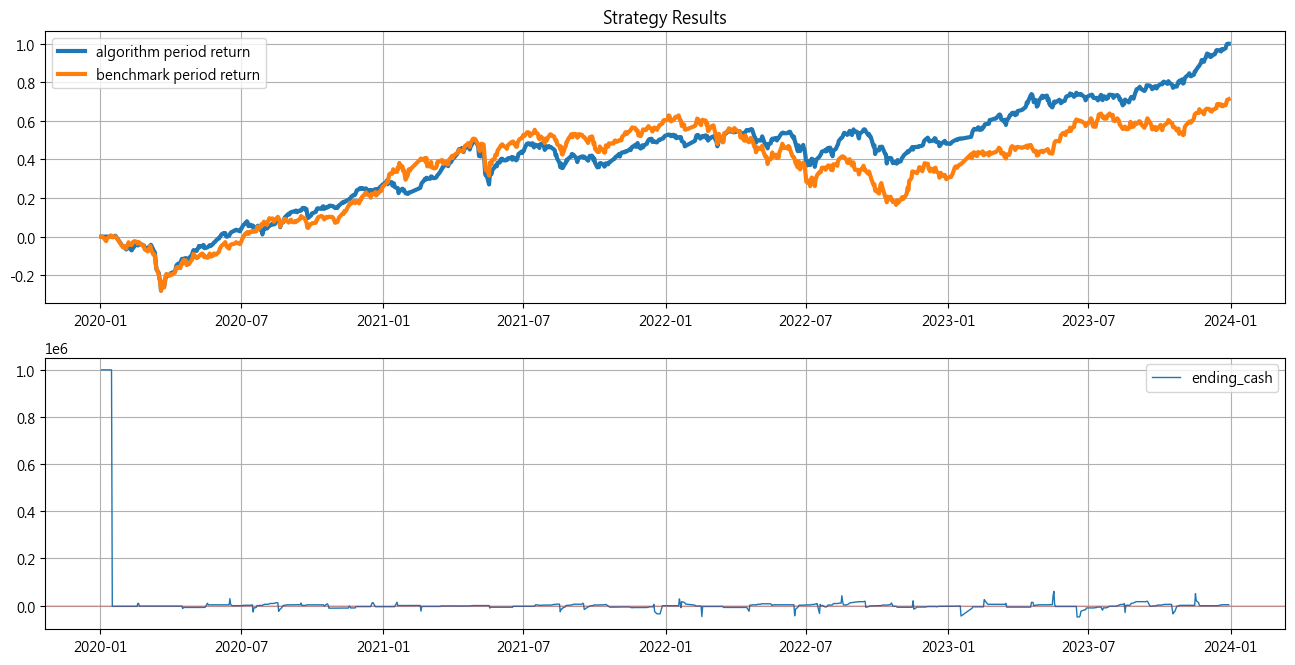

In [33]:
from zipline.algo.pipeline_algo import *

algo = TargetPercentPipeAlgo(
                     start_session=start_dt,
                     end_session=end_dt,
                     capital_base=1e6,                
                     tradeday=tradeday,
                     max_leverage=1,
                     slippage_model=slippage.VolumeShareSlippage(volume_limit=0.15, price_impact=0.01),
                     pipeline=compute_signals,
                     analyze=analyze,
                     custom_loader = Custom_loader
)

results = algo.run()

Start date,2020-01-02
End date,2023-12-29
Total months,46
,Backtest
Annual return,19.636%
Cumulative returns,99.959%
Annual volatility,15.04%
Sharpe ratio,1.27
Calmar ratio,0.69
Stability,0.84
Max drawdown,-28.292%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.29,2020-01-20,2020-03-19,2020-06-05,89
1,15.48,2021-04-28,2021-05-17,2021-12-10,158
2,12.58,2022-04-21,2022-07-12,2023-02-03,194
3,6.35,2020-07-08,2020-07-28,2020-08-17,29
4,5.44,2021-01-05,2021-02-01,2021-02-23,29


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the foll

Stress Events,mean,min,max
New Normal,0.08%,-6.96%,5.00%


Top 10 long positions of all time,max
sid,
1537,18.01%
3303,17.34%
6412,17.20%
3484,17.11%
3042,17.01%
6530,16.60%
5201,3.71%
8905,3.68%
4728,3.67%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
1537,18.01%
3303,17.34%
6412,17.20%
3484,17.11%
3042,17.01%
6530,16.60%
5201,3.71%
8905,3.68%
4728,3.67%


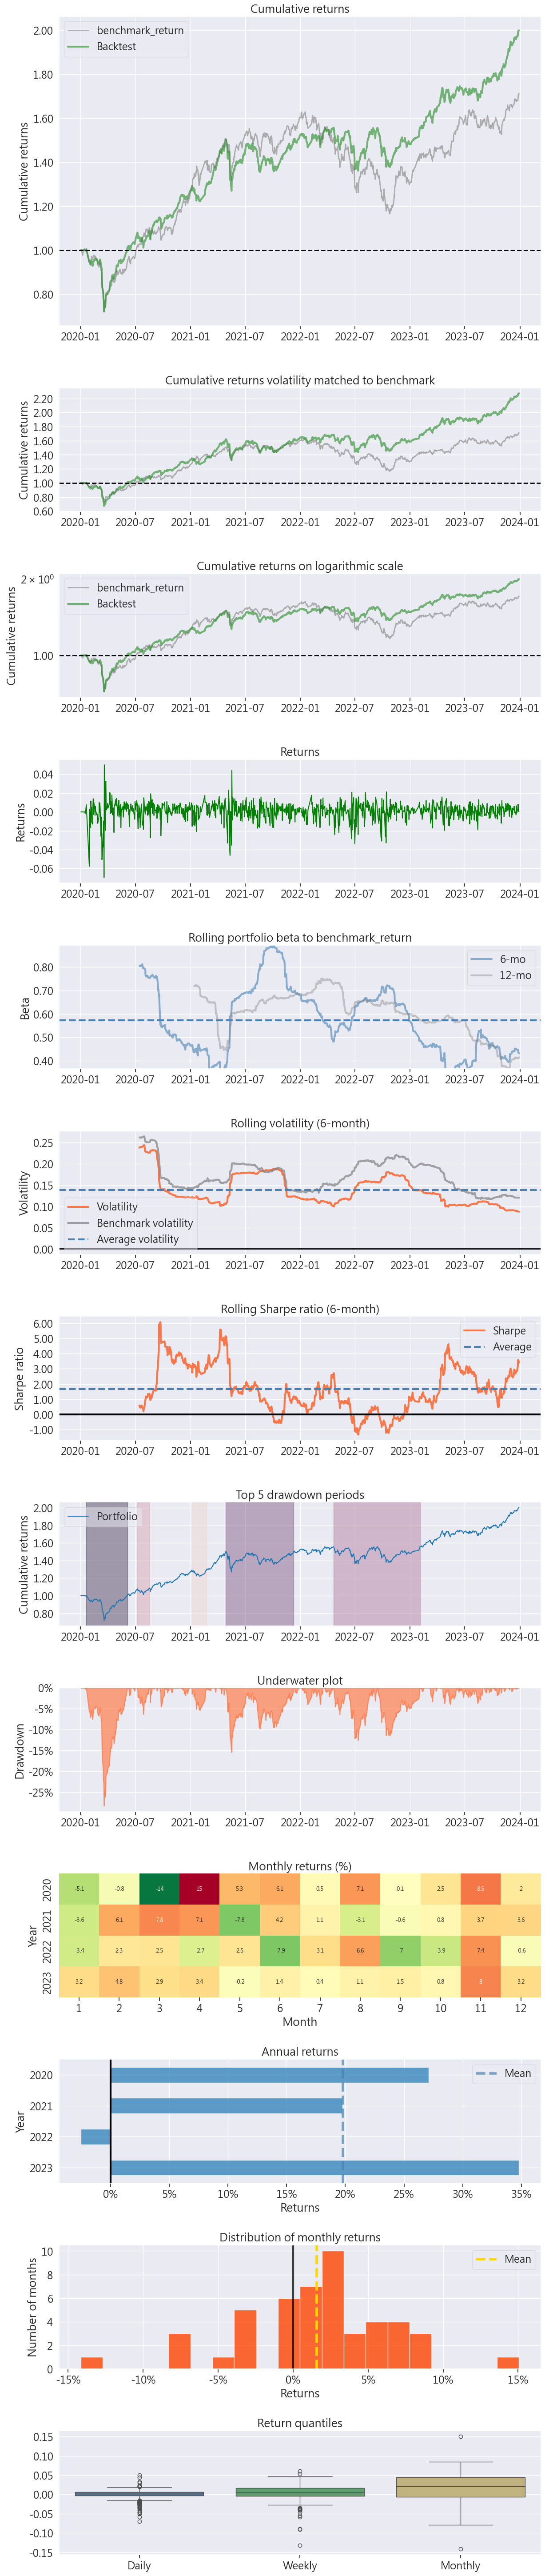

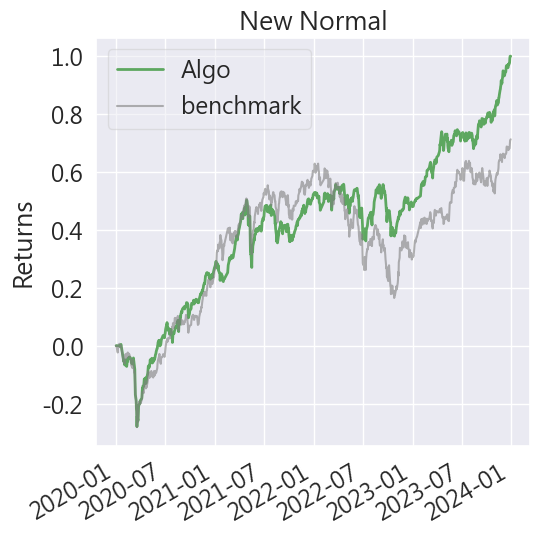

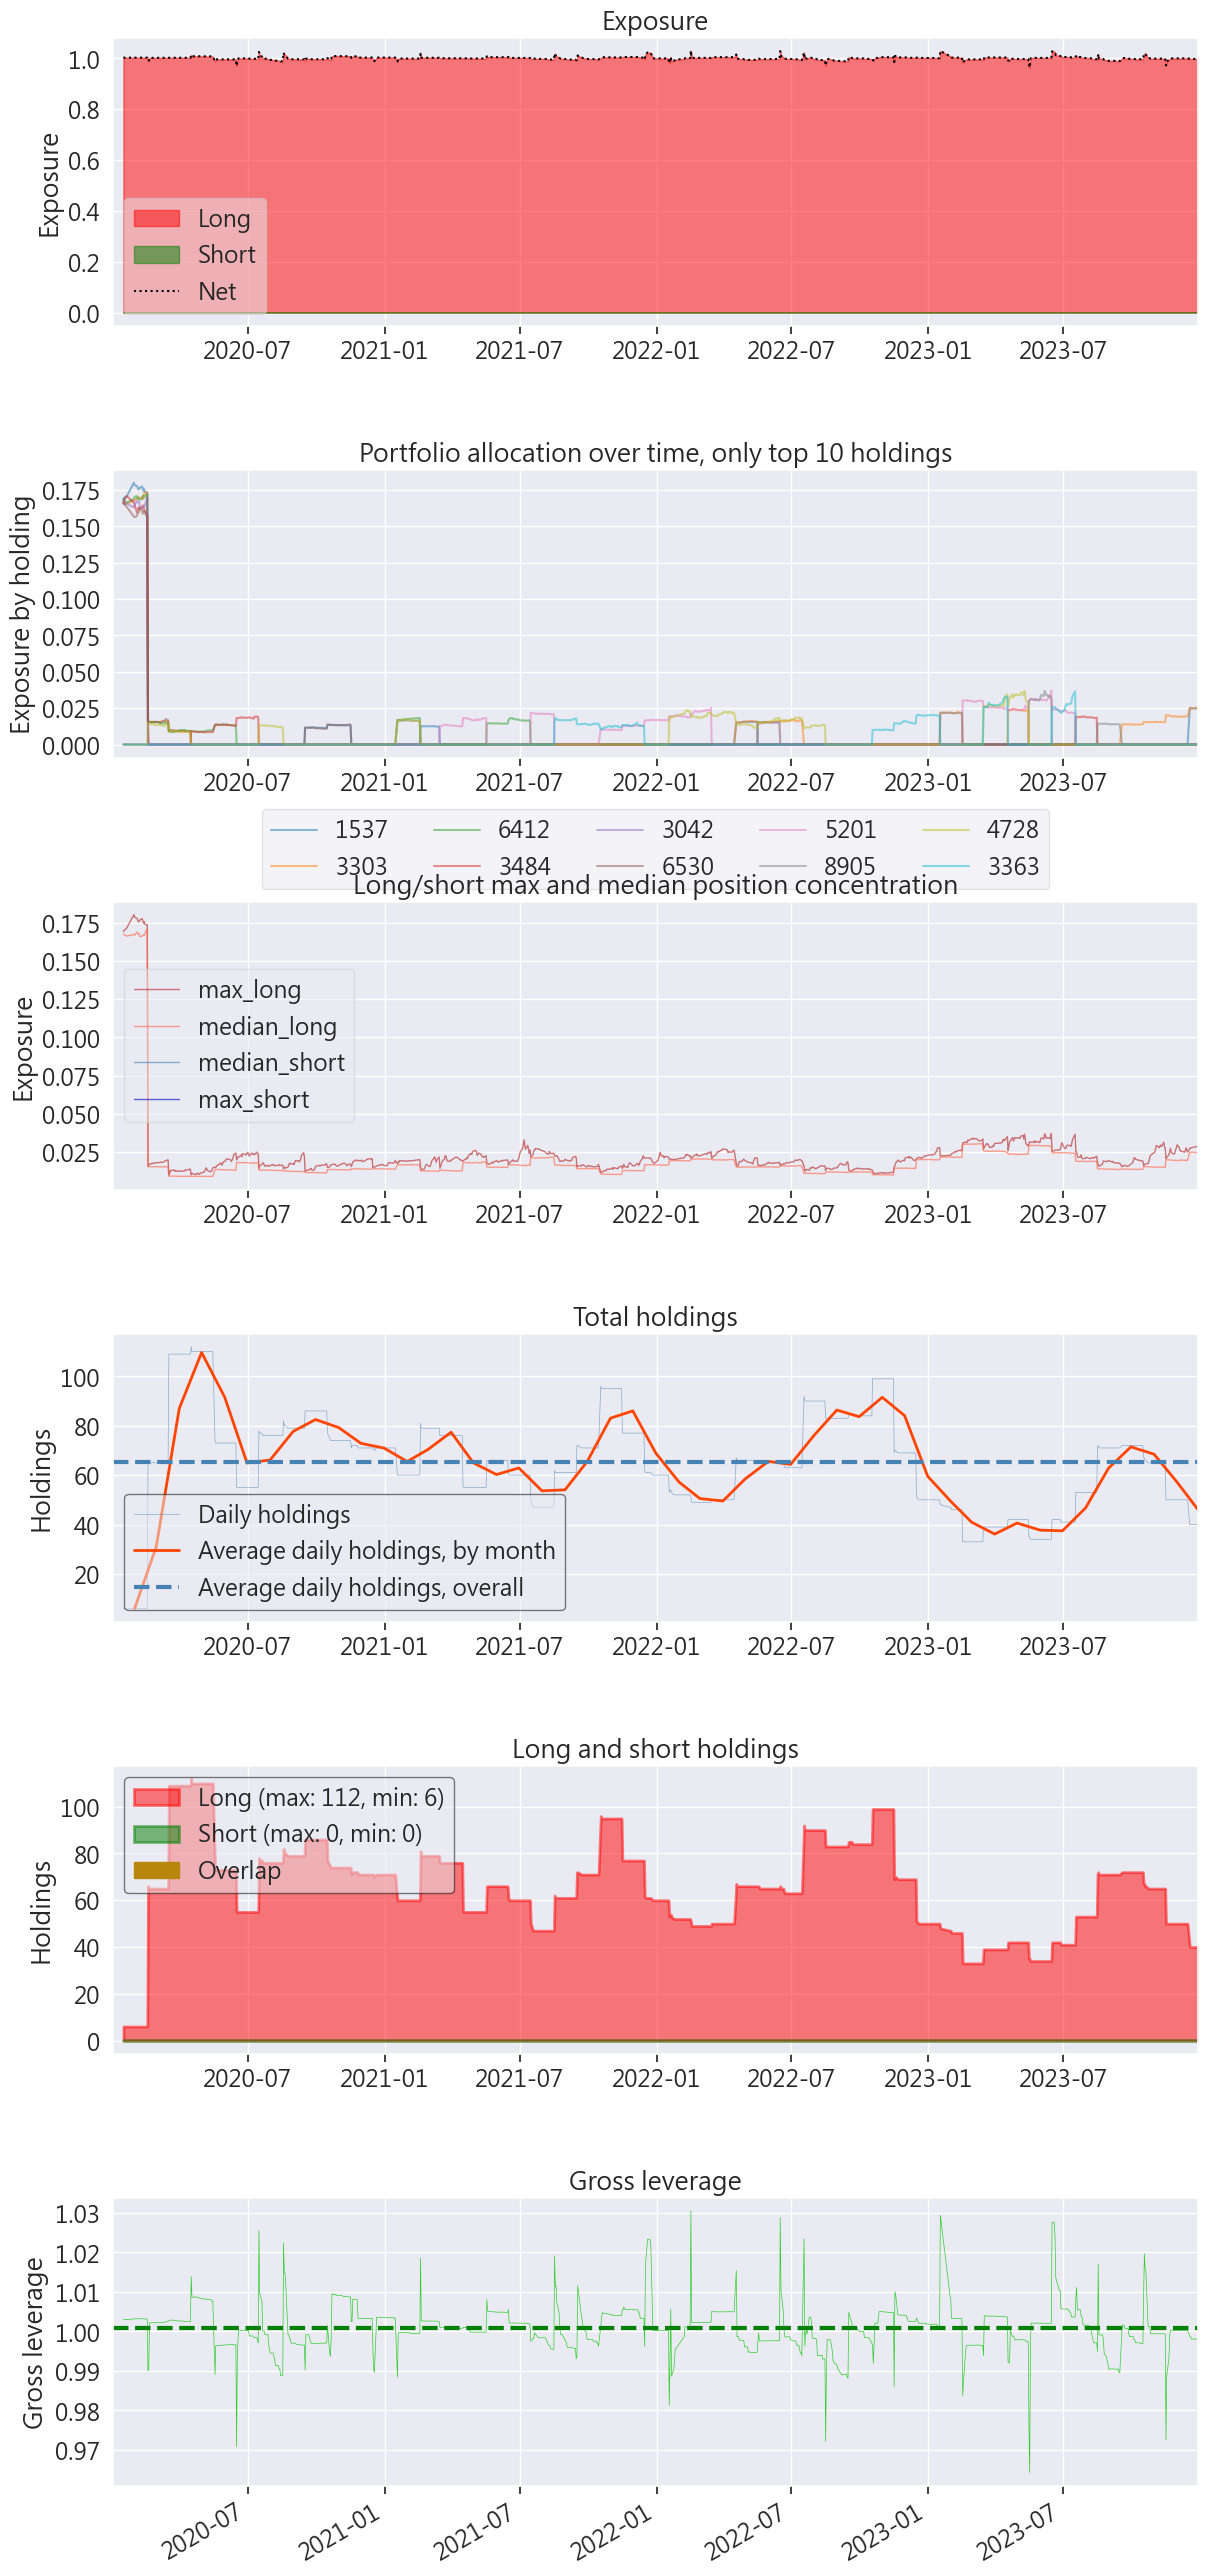

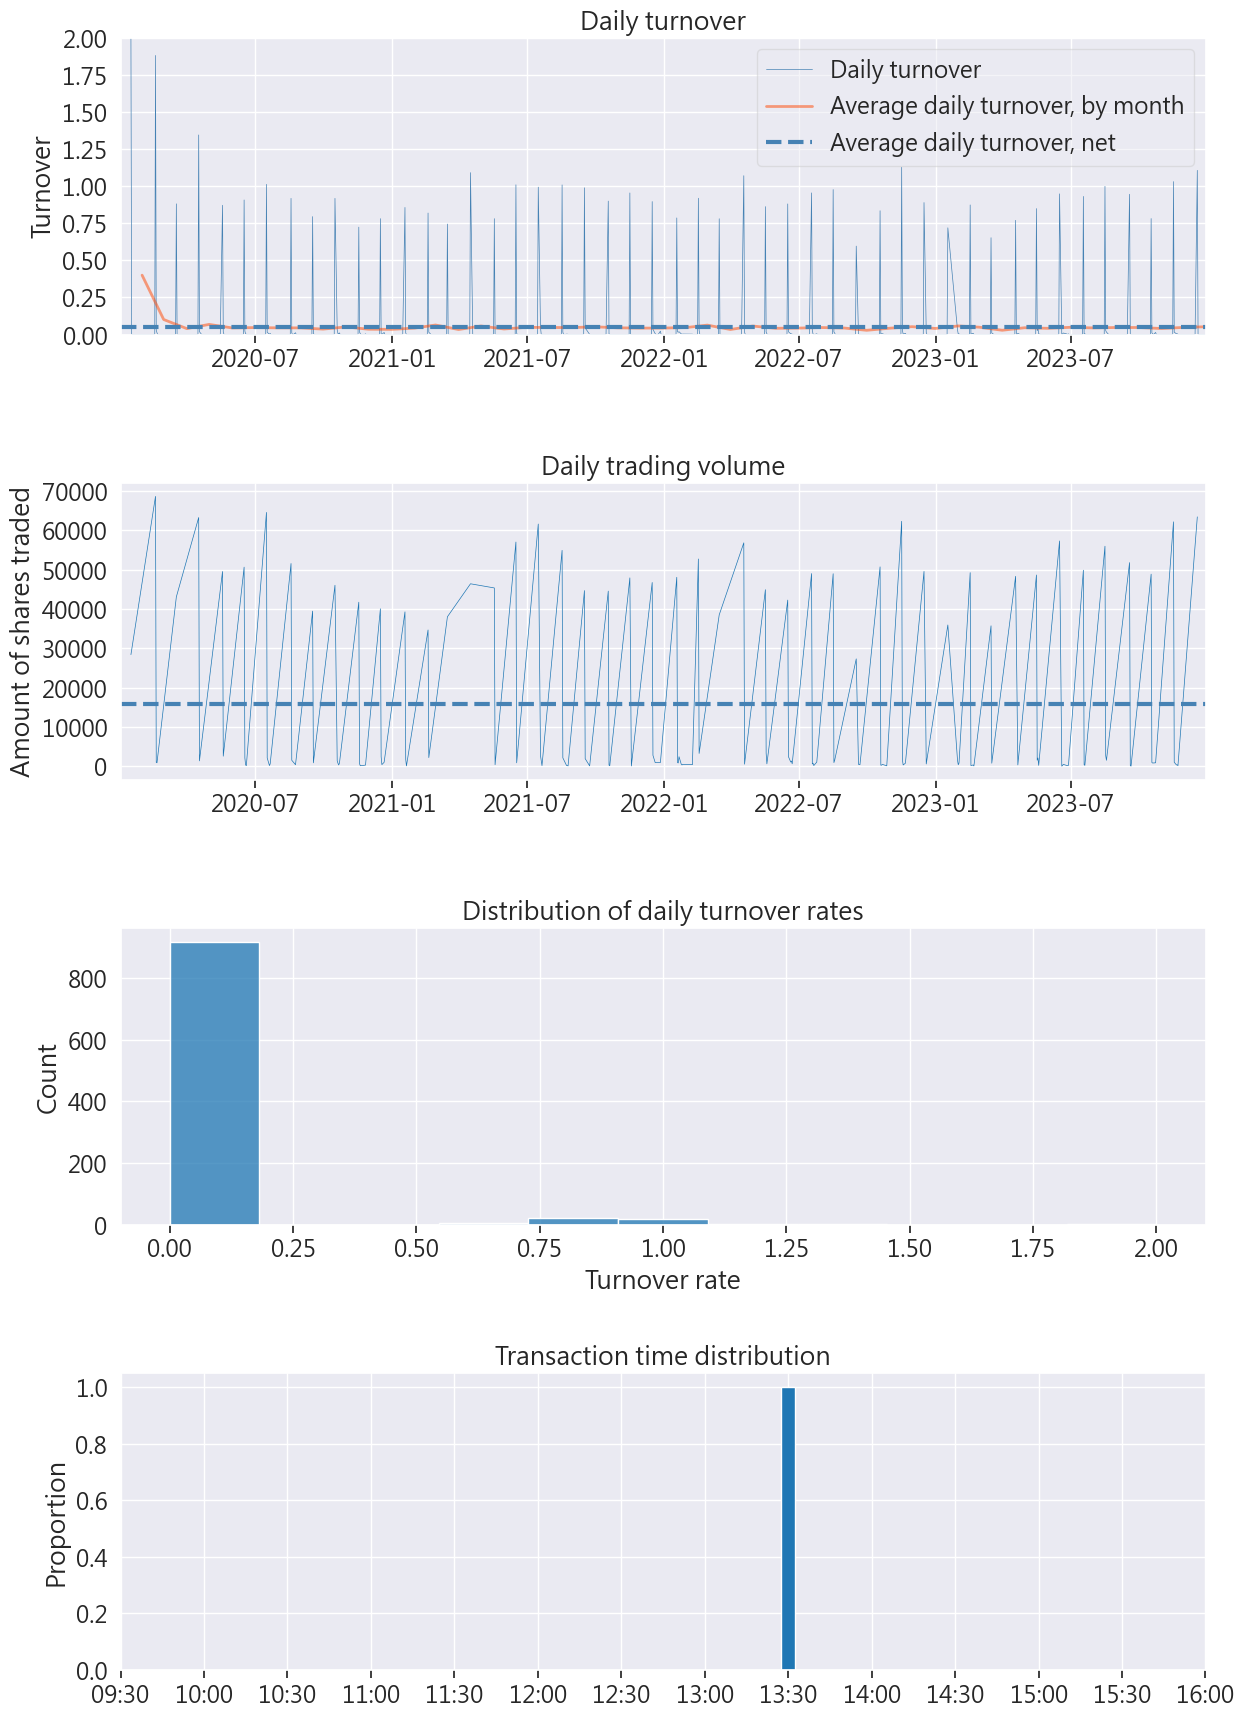

In [39]:
import pyfolio as pf

returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(returns=returns,
                          positions=positions,
                          transactions=transactions,
                          benchmark_rets=benchmark_rets
                         )